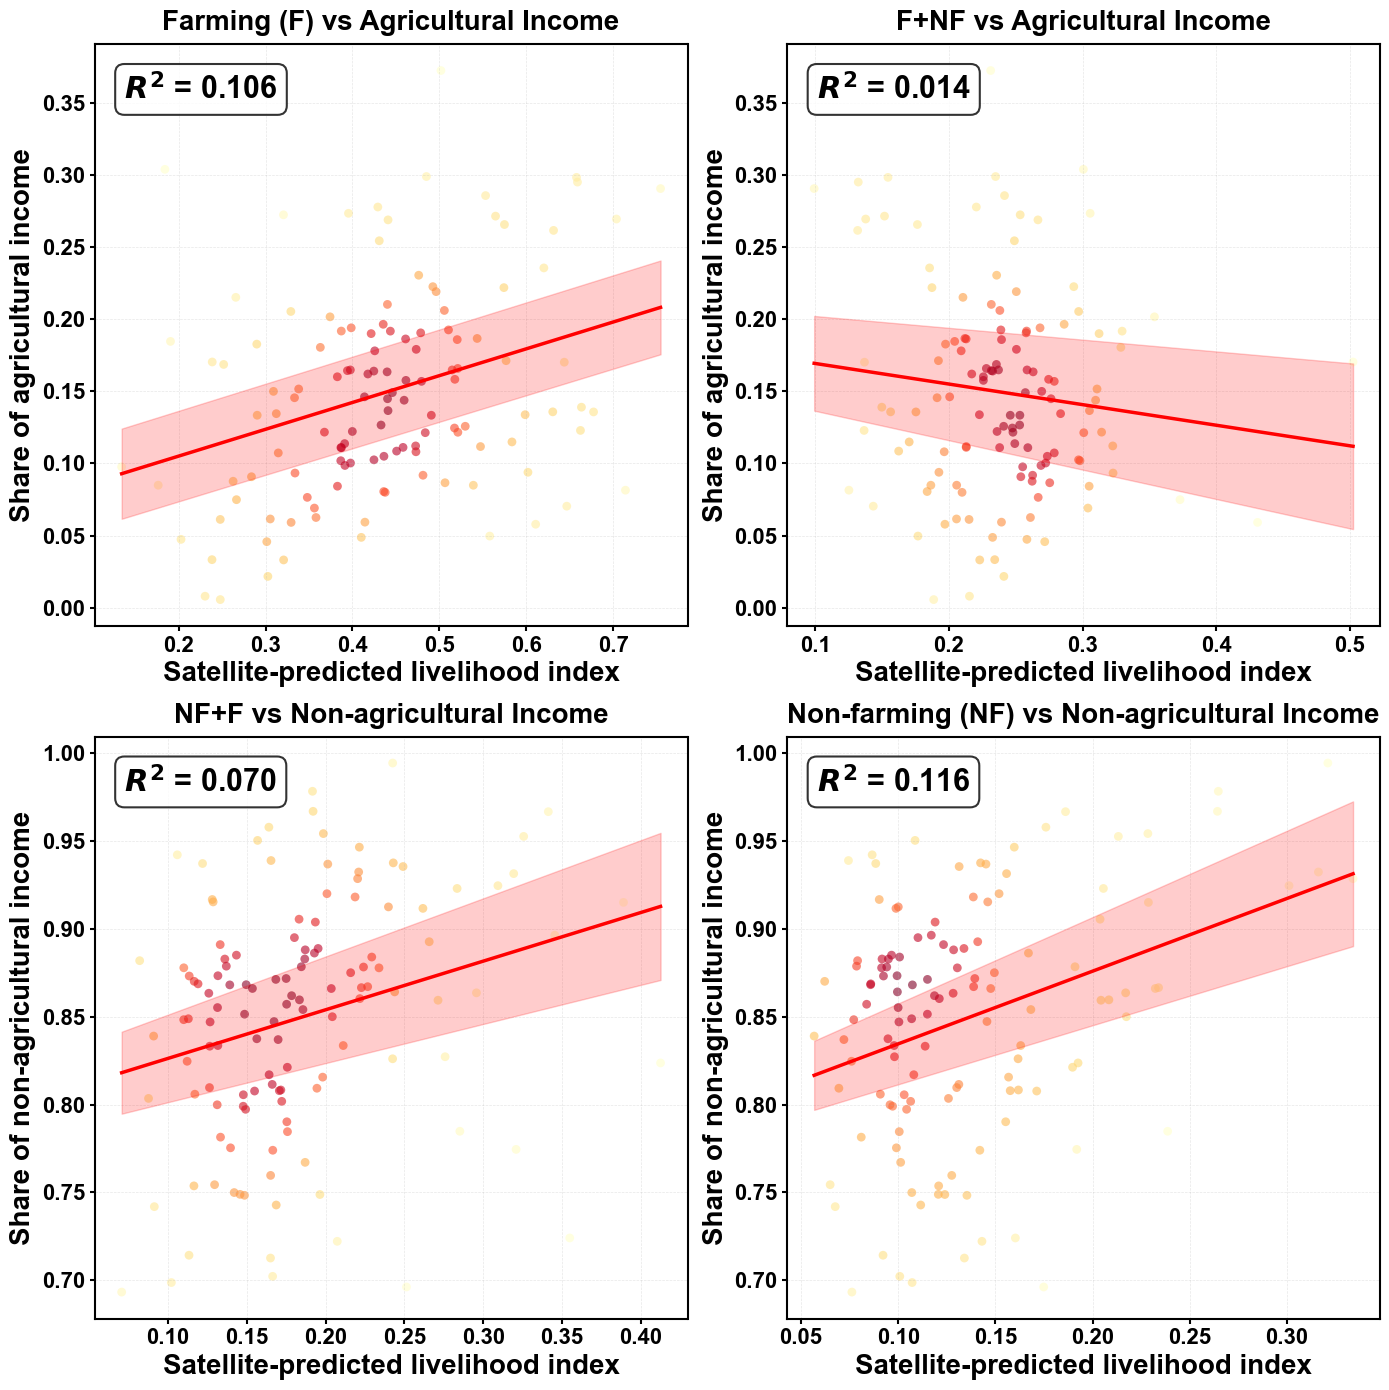

区县尺度验证结果统计:

Farming (F) vs Agricultural Income:
  样本数: 126
  R² = 0.1056
  RMSE = 0.0683
  MAE = 0.0556
  斜率 = 0.1860
  截距 = 0.0679
  p值 = 2.0523e-04
  相关系数 = 0.3250

F+NF vs Agricultural Income:
  样本数: 126
  R² = 0.0136
  RMSE = 0.0718
  MAE = 0.0579
  斜率 = -0.1426
  截距 = 0.1836
  p值 = 1.9382e-01
  相关系数 = -0.1165

NF+F vs Non-agricultural Income:
  样本数: 126
  R² = 0.0705
  RMSE = 0.0657
  MAE = 0.0526
  斜率 = 0.2765
  截距 = 0.7987
  p值 = 2.6640e-03
  相关系数 = 0.2655

Non-farming (NF) vs Non-agricultural Income:
  样本数: 126
  R² = 0.1160
  RMSE = 0.0640
  MAE = 0.0529
  斜率 = 0.4136
  截距 = 0.7932
  p值 = 9.5512e-05
  相关系数 = 0.3405



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
import seaborn as sns

# 设置全局字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# 读取数据
df = pd.read_csv(r'F:\00.博后研究\城乡连续体制图\New_NEW\04.验证\01.区县验证（CFPS）\CFPS_区县尺度验证_2020年.csv')

# 定义配对关系 - 前两个与农业收入比例对比，后两个与非农业收入比例对比
pairs = [
    ('F_Satellite', 'Share of agricultural income'),
    ('F_NF_Satellite', 'Share of agricultural income'),
    ('NF_F_Satellite', 'Share of non-agricultural income'),
    ('NF_Satellite', 'Share of non-agricultural income')
]

# 子图标题
titles = ['Farming (F) vs Agricultural Income', 
          'F+NF vs Agricultural Income', 
          'NF+F vs Non-agricultural Income', 
          'Non-farming (NF) vs Non-agricultural Income']

# 创建2x2子图
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for idx, (x_col, y_col) in enumerate(pairs):
    ax = axes[idx]
    
    # 提取数据并删除NaN
    x = df[x_col].values
    y = df[y_col].values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # 计算密度
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    # 按密度排序，使高密度点在上层
    idx_sort = np.argsort(z)
    x_sorted = x[idx_sort]
    y_sorted = y[idx_sort]
    z_sorted = z[idx_sort]
    
    # 绘制散点图（带密度颜色）
    scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=40, 
                        cmap='YlOrRd', alpha=0.6, edgecolors='none')
    
    # 线性拟合
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept
    
    # 绘制拟合线
    ax.plot(line_x, line_y, color='red', linewidth=2.5, zorder=5)
    
    # 计算置信区间（95%）
    predict_y = slope * x + intercept
    residuals = y - predict_y
    residual_std = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
    
    # 标准误差
    x_mean = np.mean(x)
    se = residual_std * np.sqrt(1/len(x) + (line_x - x_mean)**2 / np.sum((x - x_mean)**2))
    ci = 1.96 * se  # 95% 置信区间
    
    # 绘制置信区间
    ax.fill_between(line_x, line_y - ci, line_y + ci, 
                     color='red', alpha=0.2, zorder=3)
    
    # 计算R²
    r2 = r2_score(y, predict_y)
    
    # 添加R²标注（左上角）
    ax.text(0.05, 0.95, f'$R^2$ = {r2:.3f}', 
            transform=ax.transAxes, fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # 设置坐标轴标签
    ax.set_xlabel('Satellite-predicted livelihood index', 
                  fontsize=20, fontweight='bold', color='black')
    
    # 根据Y轴变量设置不同的标签
    if 'agricultural' in y_col.lower() and 'non' not in y_col.lower():
        ylabel = 'Share of agricultural income'
    else:
        ylabel = 'Share of non-agricultural income'
    
    ax.set_ylabel(ylabel, fontsize=20, fontweight='bold', color='black')
    
    # 设置子图标题
    ax.set_title(titles[idx], fontsize=20, fontweight='bold', 
                color='black', pad=10)
    
    # 设置刻度标签加粗
    ax.tick_params(axis='both', labelsize=16, width=1.5)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_color('black')
    
    # 加粗边框
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('black')
    
    # 设置网格（可选）
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# 调整子图间距
plt.tight_layout()

# 保存图片
plt.savefig(r'F:\00.博后研究\城乡连续体制图\New_NEW\04.验证\01.区县验证（CFPS）\validation_scatter_county.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 打印统计结果
print("=" * 70)
print("区县尺度验证结果统计:")
print("=" * 70)
for idx, (x_col, y_col) in enumerate(pairs):
    x = df[x_col].dropna().values
    y = df[y_col].dropna().values
    
    # 同时删除两列中的NaN
    valid_idx = ~(pd.isna(df[x_col]) | pd.isna(df[y_col]))
    x = df.loc[valid_idx, x_col].values
    y = df.loc[valid_idx, y_col].values
    
    if len(x) > 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        predict_y = slope * x + intercept
        r2 = r2_score(y, predict_y)
        rmse = np.sqrt(np.mean((y - predict_y)**2))
        mae = np.mean(np.abs(y - predict_y))
        
        print(f"\n{titles[idx]}:")
        print(f"  样本数: {len(x)}")
        print(f"  R² = {r2:.4f}")
        print(f"  RMSE = {rmse:.4f}")
        print(f"  MAE = {mae:.4f}")
        print(f"  斜率 = {slope:.4f}")
        print(f"  截距 = {intercept:.4f}")
        print(f"  p值 = {p_value:.4e}")
        print(f"  相关系数 = {r_value:.4f}")
    else:
        print(f"\n{titles[idx]}: 无有效数据")

print("\n" + "=" * 70)